# Bayes-by-backprop
## Rotating MNIST

In [2]:
import jax
import optax
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from chex import dataclass
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jaxtyping import Float, Array
from flax.training.train_state import TrainState

from dynamax.utils import datasets
from dynamax.rebayes import bayes_by_backprop as bbb

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## Load dataset

In [4]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

## Loss function

In [5]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float

def cost_fn(
    key: jax.random.PRNGKey,
    state: bbb.BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam
):
    """
    TODO:
    Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    # Sampled params
    params = bbb.sample_params(key, state, reconstruct_fn)
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()

    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, logvar, x: distrax.Normal(loc=mean, scale=jnp.exp(logvar / 2)).log_prob(x),
        state.mean, state.logvar, params
    )
    logp_variational = bbb.get_leaves(logp_variational).sum()
    
    return logp_variational - logp_prior - logp_obs


def lossfn(key, params, X, y, model, reconstruct_fn, priors, num_samples=10):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn, model, priors).mean()
    return loss


@partial(jax.vmap, in_axes=(0, None, None, None))
@partial(jax.jit, static_argnames=("reconstruct_fn",))
def sample_and_eval(key, state, X, reconstruct_fn):
    params_sample = bbb.sample_params(key, state, reconstruct_fn)
    return model.apply(params_sample, X)


@partial(jax.jit, static_argnames=("reconstruct_fn", "num_samples"))
def eval_mae(key, params, X, y, reconstruct_fn, num_samples=20):
    keys_sample = jax.random.split(key, num_samples)
    yhat_samples = sample_and_eval(keys_sample, params, X, reconstruct_fn).squeeze()
    yhat = yhat_samples.mean(axis=0)
    err_pp = y - yhat
    return jnp.abs(err_pp).mean(), yhat

## Model setup

In [6]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        
        return x

In [7]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [8]:
batch = (100, 28 ** 2)
model = MLP(1, dim_hidden=200)
batch = jnp.ones(batch)

In [9]:
batch_size = 100
num_epochs = 2000
tx = optax.adam(1e-3)
keys_epochs = jax.random.split(key_train, num_epochs)

priors = PriorParam(scale_obs=2.0, scale_weight=0.5)
part_lossfn = partial(lossfn, priors=priors)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = bbb.init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

In [11]:
%%time
losses = []
test_mae = []
# for key_epoch in (pbar := tqdm(keys_epochs)):
for epoch in (pbar := tqdm(range(num_epochs))):
    key_epoch = jax.random.fold_in(key_train, epoch)
    loss, opt_state = bbb.train_epoch(key_epoch, opt_state, X_train, y_train, batch_size, part_lossfn, model, reconstruct_fn)
    vmae, _ = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn)
    pbar.set_description(f"{loss=:0.4e} | {vmae=:0.4f}")
    
    test_mae.append(vmae)
    losses.append(loss)
    
losses = np.array(losses)
test_mae = np.array(test_mae)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 2min 44s, sys: 34.9 s, total: 3min 19s
Wall time: 4min 9s


## Model evaluation

In [12]:
mae, yhat_test = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn)
mae

DeviceArray(12.698784, dtype=float32)

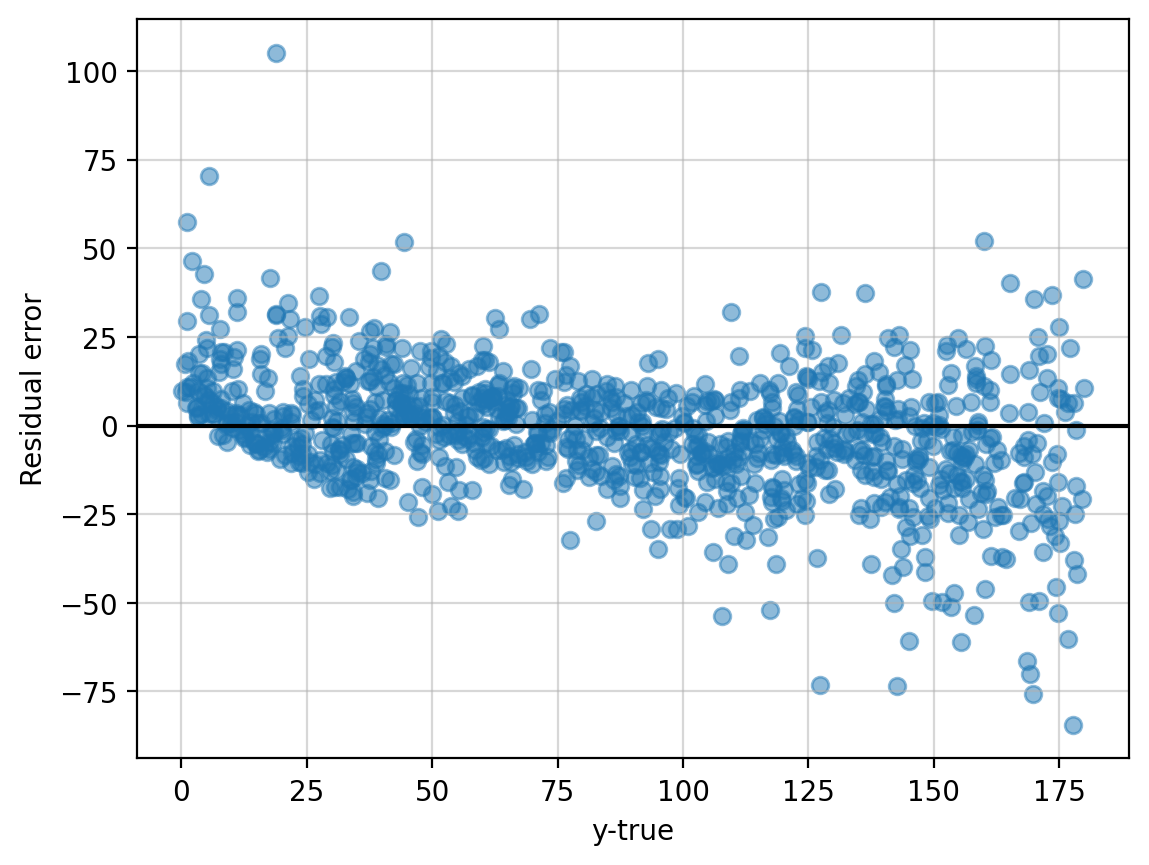

In [13]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

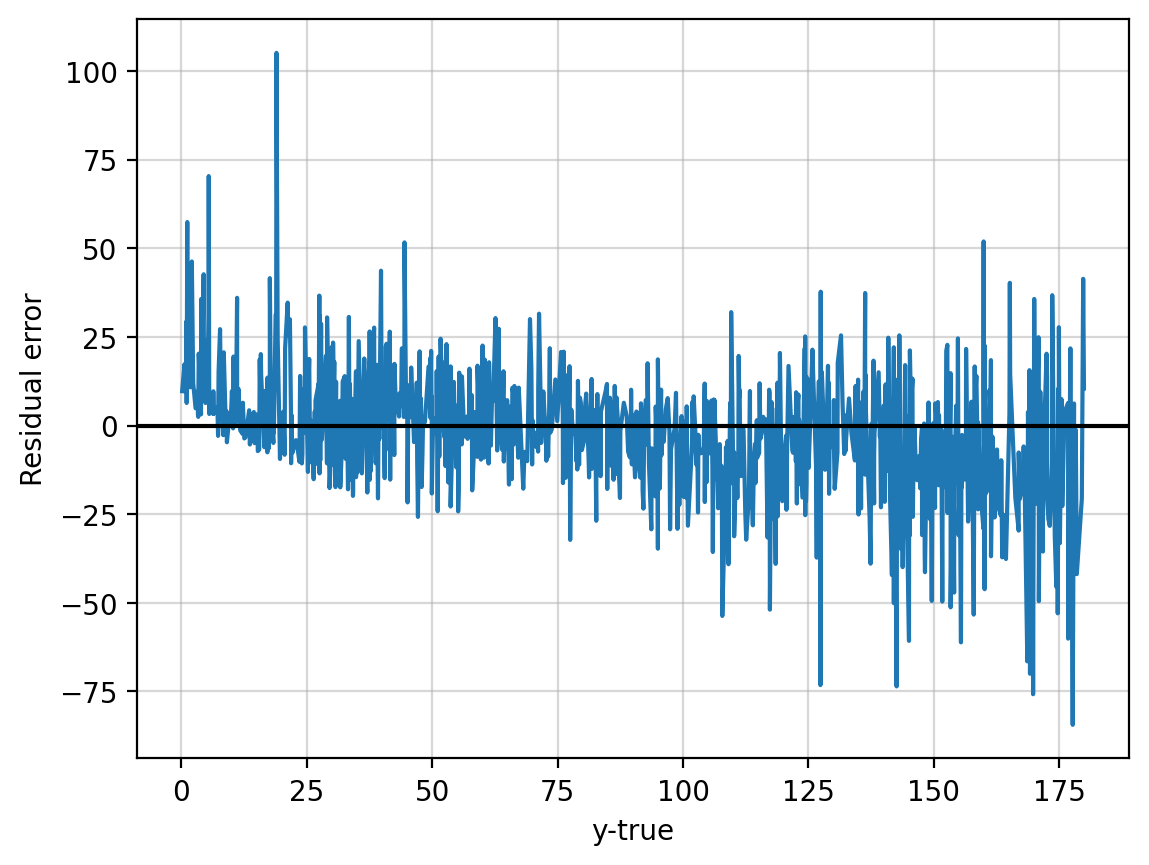

In [14]:
ix_sort = jnp.argsort(y_test)
residual_err = yhat_test - y_test
plt.plot(y_test[ix_sort], residual_err[ix_sort])
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

## Uncertainty evaluation

## Replay buffer — FIFO

In [299]:
np.random.seed(3141)
num_train = 100
num_train = 5_000

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

choice_ix = np.random.choice(len(X_train), size=num_train)
X_train = jnp.array(X_train)[choice_ix]
y_train = jnp.array(y_train)[choice_ix]

ix_sort = jnp.argsort(y_train)
X_train = X_train[ix_sort]
y_train = y_train[ix_sort]

In [301]:
def cost_fn(
    key: jax.random.PRNGKey,
    state: bbb.BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    ixs: Int[Array, "batch_size"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam
):
    """
    Modified cost function for FIFO batches
    
    loss = log q(θ) - log p(θ) - log p(D|θ)
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    # Sampled params
    params = bbb.sample_params(key, state, reconstruct_fn)
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y)
    counter = (ixs >= 0)
    logp_obs = (logp_obs * counter).sum()
    

    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, logvar, x: distrax.Normal(loc=mean, scale=jnp.exp(logvar / 2)).log_prob(x),
        state.mean, state.logvar, params
    )
    logp_variational = bbb.get_leaves(logp_variational).sum()
    
    return logp_variational - logp_prior - logp_obs


def lossfn(key, params, X, y, ixs, model, reconstruct_fn, priors, num_samples=30):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, ixs, reconstruct_fn, model, priors).mean()
    return loss


In [302]:
def get_fifo_batches(ix, buffer_size):
    ix_lookback = (ix - buffer_size) + 1
    batches = jnp.arange(buffer_size) + ix_lookback
    return batches


def train_step(key, opt_state, X, y, ixs, lossfn, model, reconstruct_fn):
    params = opt_state.params
    apply_fn = opt_state.apply_fn
    loss, grads = jax.value_and_grad(lossfn, 1)(key, params, X, y, ixs, model, reconstruct_fn)
    opt_state_new = opt_state.apply_gradients(grads=grads)
    return opt_state_new, loss

In [303]:
@partial(jax.jit, static_argnames=("lossfn", "model", "reconstruct_fn", "buffer_size"))
def split_and_fifo_step(key, opt_state, X, y, step, lossfn, model, reconstruct_fn, buffer_size):
    ixs = get_fifo_batches(step, buffer_size)
    X_batch, y_batch = X[ixs], y[ixs]
    opt_state, loss = train_step(key, opt_state, X_batch, y_batch, ixs, lossfn, model, reconstruct_fn)
    return opt_state, loss

In [304]:
buffer_size = 10
batch = (buffer_size, 28 ** 2)
model = MLP(1, dim_hidden=200)
batch = jnp.ones(batch)

In [305]:
tx = optax.adam(1e-4)

priors = PriorParam(scale_obs=2.0, scale_weight=0.5)
part_lossfn = partial(lossfn, priors=priors)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = bbb.init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)


losses = []
test_mae = []
for i in (pbar := tqdm(range(num_train))):
    for _ in range(3):
        key_step = jax.random.fold_in(key_train, i)
        opt_state, loss = split_and_fifo_step(key_step, opt_state, X_train, y_train, i, part_lossfn, model, reconstruct_fn, buffer_size)
    vmae, _ = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, num_samples=50)
    pbar.set_description(f"{loss=:0.4e} | {vmae=:0.4f}")
    
    test_mae.append(vmae)
    losses.append(loss)
    
losses = np.array(losses)
test_mae = np.array(test_mae)

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAE on test set')

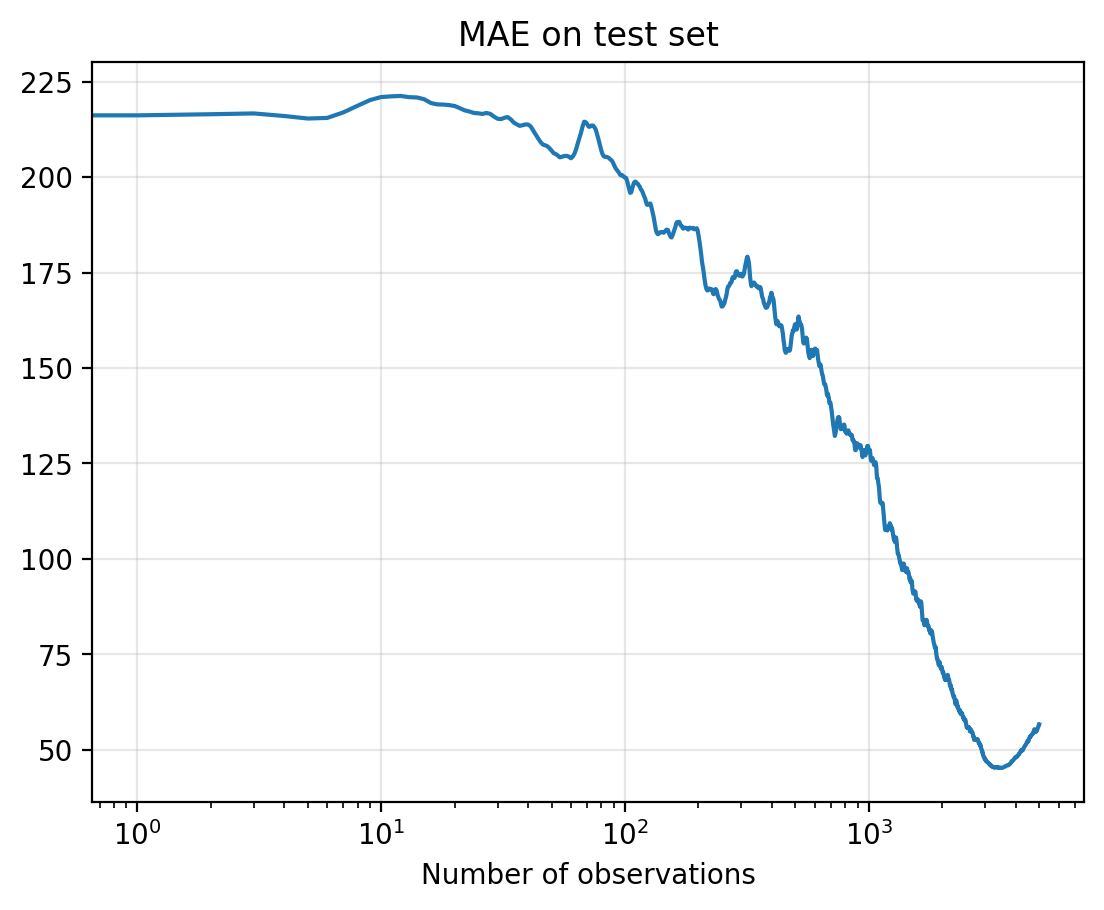

In [323]:
plt.plot(test_mae)
plt.xscale("log")
plt.grid(alpha=0.3)
plt.xlabel("Number of observations")
plt.title("MAE on test set")

In [321]:
mae, yhat_test = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, num_samples=100)
mae

DeviceArray(59.35762, dtype=float32)

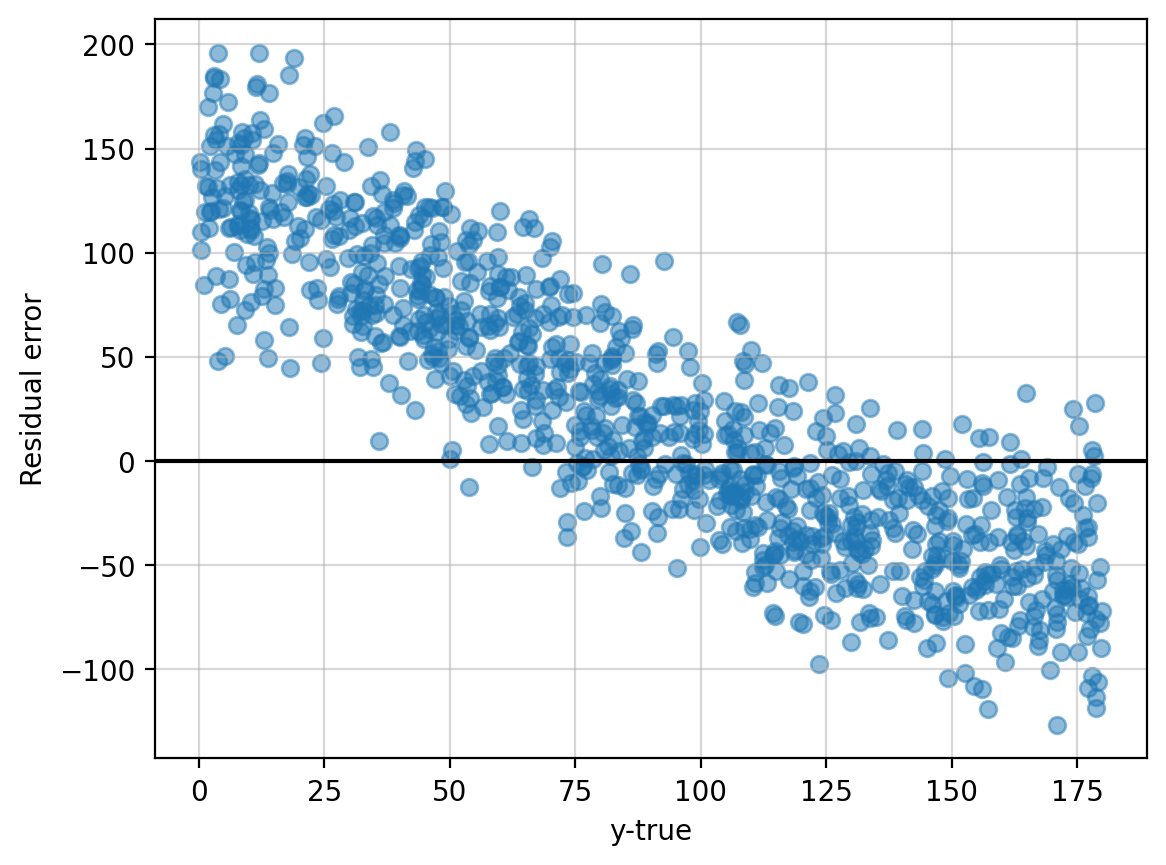

In [322]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)